In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
N_CLASSES = 10
EPOCHS = 150


In [3]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


In [4]:
train_generator = train_datagen.flow_from_directory(
    "split_dataset/train",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    "split_dataset/val",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    "split_dataset/test",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=False
)

class_names = list(train_generator.class_indices.keys())


Found 18339 images belonging to 10 classes.
Found 2289 images belonging to 10 classes.
Found 2302 images belonging to 10 classes.


In [5]:
base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False  # 🔒 Freeze backbone


In [6]:
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(512, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

output = layers.Dense(N_CLASSES, activation="softmax")(x)

model = models.Model(inputs=base_model.input, outputs=output)


In [7]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [8]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=7,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stopping]
)


Epoch 1/30
574/574 [==============================] - 181s 303ms/step - loss: 0.8492 - accuracy: 0.7252 - val_loss: 0.3242 - val_accuracy: 0.8973
Epoch 2/30
574/574 [==============================] - 143s 250ms/step - loss: 0.3656 - accuracy: 0.8771 - val_loss: 0.2665 - val_accuracy: 0.9083
Epoch 3/30
574/574 [==============================] - 118s 205ms/step - loss: 0.2800 - accuracy: 0.9059 - val_loss: 0.1914 - val_accuracy: 0.9384
Epoch 4/30
574/574 [==============================] - 117s 204ms/step - loss: 0.2270 - accuracy: 0.9233 - val_loss: 0.2066 - val_accuracy: 0.9292
Epoch 5/30
574/574 [==============================] - 201s 350ms/step - loss: 0.2042 - accuracy: 0.9299 - val_loss: 0.1692 - val_accuracy: 0.9432
Epoch 6/30
574/574 [==============================] - 119s 208ms/step - loss: 0.1807 - accuracy: 0.9401 - val_loss: 0.1470 - val_accuracy: 0.9489
Epoch 7/30
574/574 [==============================] - 115s 200ms/step - loss: 0.1636 - accuracy: 0.9455 - val_loss: 0.1797 -

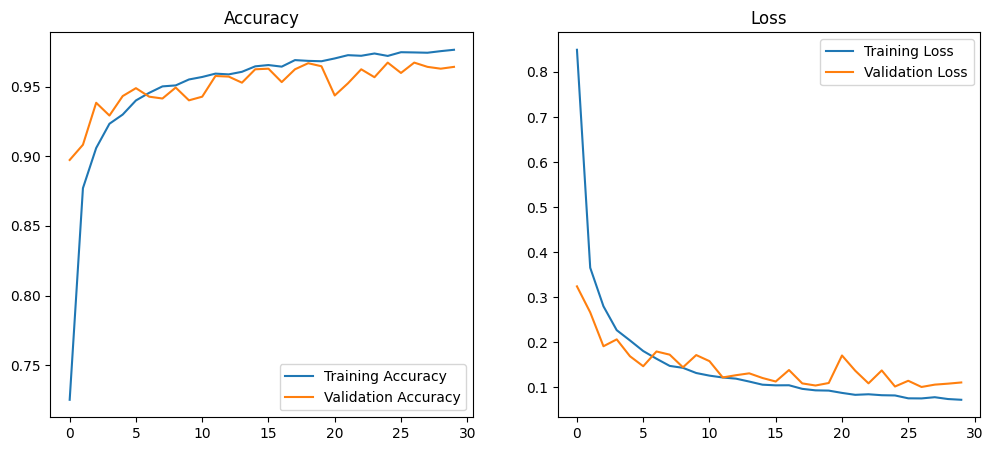

In [9]:
# Plot Accuracy & Loss
# --------------------------
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()


In [10]:
# Evaluate Test Set
# --------------------------
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

72/72 [==============================] - 10s 137ms/step - loss: 0.1107 - accuracy: 0.9631
Test Loss: 0.1107, Test Accuracy: 0.9631


72/72 [==============================] - 10s 138ms/step


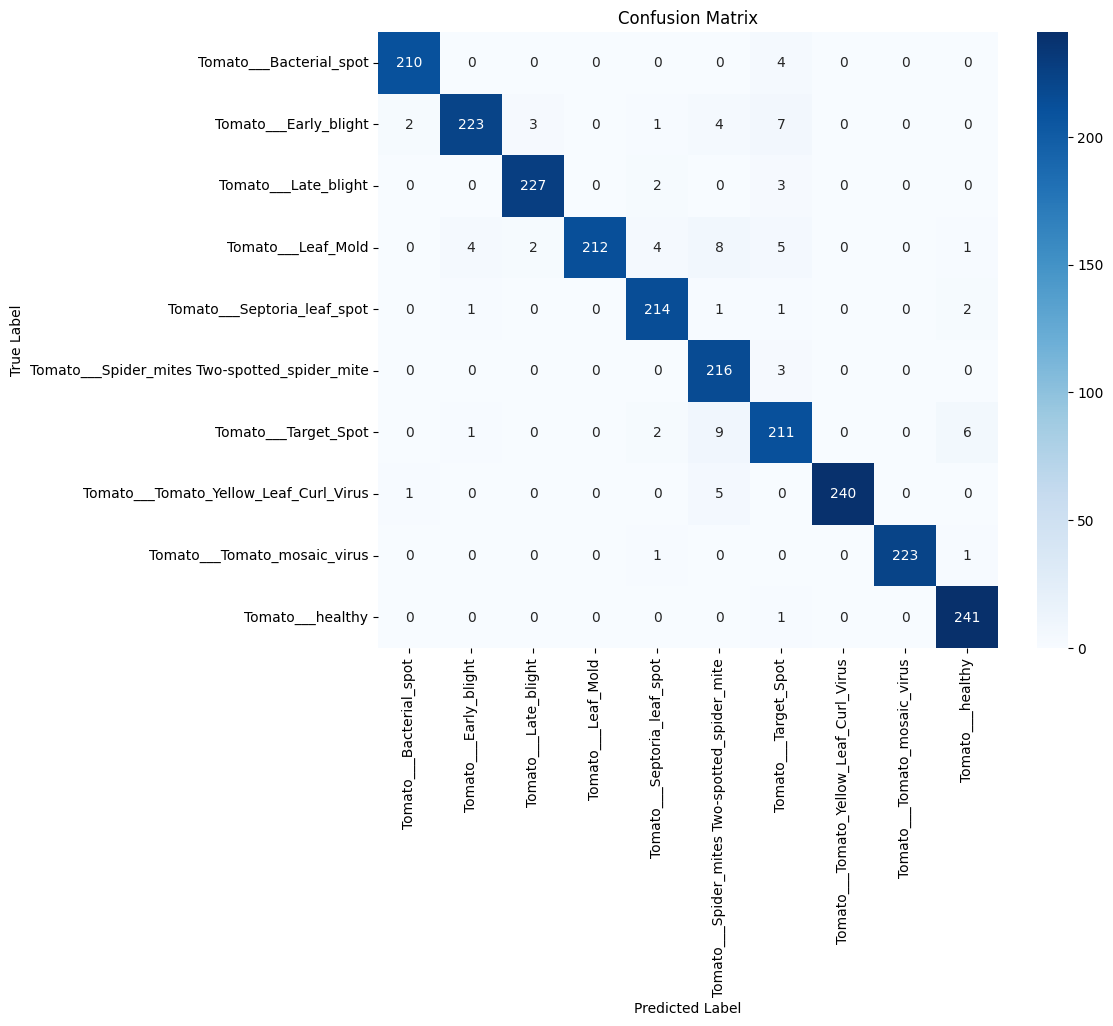

In [11]:
# Confusion Matrix & Classification Report
# --------------------------
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

In [12]:
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.99      0.98      0.98       214
                        Tomato___Early_blight       0.97      0.93      0.95       240
                         Tomato___Late_blight       0.98      0.98      0.98       232
                           Tomato___Leaf_Mold       1.00      0.90      0.95       236
                  Tomato___Septoria_leaf_spot       0.96      0.98      0.97       219
Tomato___Spider_mites Two-spotted_spider_mite       0.89      0.99      0.94       219
                         Tomato___Target_Spot       0.90      0.92      0.91       229
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       1.00      0.98      0.99       246
                 Tomato___Tomato_mosaic_virus       1.00      0.99      1.00       225
                             Tomato___healthy       0.96      1.00      0.98       242

                                     accu

In [13]:
model.save("tomato_resnet_model.h5")
